Analysis of eye tracking files from Spiro study.
Gaze dispersion metric based on Christoforou et al, 2015: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4428128/pdf/fpsyg-06-00579.pdf
The objective is as follows:
(1) compute within-subject dispersion metric, based on short sections of the film (250 ms with 50 ms shift, ie 80% overlap)
(2) get sections with extreme dispersion score


In [1]:
# analyse film data, v3 Oct/Nov 2020

# read and prep Tobii .tsv files from CortEx study
import os
from datetime import datetime
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import nanmedian, nanmean, nanstd
from scipy.spatial import distance
from scipy import stats
from sklearn.metrics import pairwise_distances
import warnings
warnings.filterwarnings('ignore')

Utils

In [2]:
from scipy.stats import norm
# get participant numbers

def get_pnums(infiles):
    """
    Get participant numbers from filenames.

    Parameters
    ----------
    infiles: array of input file names

    Returns
    -------
    list of participant numbers 
    """
    id = []
    for i,filenames in enumerate(infiles):
        pnum = [int(s) for s in filenames.split('_') if s.isdigit()]
        id.append([pnum])

def flatten(list_name):
    """ 
    Function that flattens list of lists.
    Source: https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists

    Parameters
    ----------
    list_name: str
        Name of the list to flatten
    
    Returns
    -------
    Flattened list
    """
    flattened = [item for sublist in list_name for item in sublist]
    return flattened



def get_random_samps(df, frame_num_max, id):
    """ 
    Fit a participant's gaze data to normal distribution.
    Randomly sample normal distribution with participant-specific mean and std.

    Parameters
    ----------
    df: pandas dataframe
        dataframe holding eye tracking data from all participants

    frame_num_max: int
        maximum number of frames for participant, will be used to determine how many samples to draw

    id: int
        participant id 
    
    Returns
    -------
    Simulated gaze data in x and y.

    """
    # first, let's simulate some gaze data.
    # some basic parameters
    #gaze_length = df.frame_num.max() # number of samples we need to generate
    mux,stdx = norm.fit(df.loc[df.id == id,'gaze_in_x'])
    muy,stdy = norm.fit(df.loc[df.id == id, 'gaze_in_y'])
    # get samples
    sim_in_x = norm.rvs(loc = mux, scale = stdx, size = frame_num_max)
    sim_in_y = norm.rvs(loc = muy, scale = stdy, size = frame_num_max)
    return sim_in_x, sim_in_y

def calculate_dispersion_scores(frame_num, gaze_x, gaze_y,window_size, window_step):
    """
    Calculate dispersion scores for each window.

    Parameters
    ----------
    frame_num: array of float
        frame number
    gaze_x, gaze_y: pandas DataFrame
        gaze positions in x and y
    window_size: int
        size of window (how many frames)
    window_step: int
        number of frames to move each time the window slides (ie overlap between windows)
    
    Returns
    -------
    list containing mean score per window
    """

    #et_df.loc[:,['frame_num','gaze_in_x','gaze_in_y']].groupby('frame_num').rolling(window = 15, min_periods = 3).apply(distance.euclidean)
    dists = []
    for i in frame_num:
        frame_df = pd.concat([gaze_x.loc[i,:],gaze_y.loc[i,:]],axis = 1)
        frame_dist_val =  np.unique(pairwise_distances(frame_df.dropna(), frame_df.dropna(),force_all_finite = True)).mean()
        dists.append(frame_dist_val)

     # now we calculate the mean euclidean distance for each window.
   # pwise_dists = pd.Series(dists, index = gaze_x.index)
  #  windows = pwise_dists.rolling(window = 15)
    steps = np.arange(0,len(dists)-15,window_step)

    # now calculate the mean for each 15-frame window (corresponds to ~250 ms), with a step size of 3 (80% overlap between successive windows)
    wind_dists = []
    for i in steps:
        wind_dist = np.array(dists)[i:i+window_size].mean()
        wind_dists.append(wind_dist)
    wind_dists = pd.Series(wind_dists)
    return wind_dists


In [3]:
class Tobii_file:
    def __init__(self, filename, film_dur_s, screenres_x = None, screenres_y = None, s_rate= None):
        """
    
        """
        if not screenres_x:
            self.screen_resx = 1280
        if not screenres_y:
            self.screen_resy = 1024
        if not s_rate:
            s_rate = 60
        self.filename = filename
        self.screen_res = [screenres_x, screenres_y]
        self.s_rate = s_rate
        self.film_dur_s = film_dur_s
        self.pnum = [int(s) for s in filename.split('_') if s.isdigit()]

    def get_calibration(self, calibration_filename, calibration_dir):
        """
        Get calibration details (accuracy, precision).

        Parameters
        ----------
        filename: str
            Calibration filename
        calibration file directory: str
            path to calibration file directory
        
        Returns
        -------
        

        """
        self.calibration_filename = calibration_filename
        calibration_df = pd.read_csv(os.path.join(calibration_dir,calibration_filename))
        if calibration_df.loc[calibration_df['used']=='used','used'].empty:
            self.calibration = 'unused'
        else:
            self.calibration = calibration_df.loc[calibration_df['used'] == 'used',:]



(i) get time stamps from message file
- discard everything but the messages containing frame nr.
(ii) load data file and add column for frame nr
(iii) label rows between message (framenr) time stamps with the appropriate frame nr

In [3]:
home = 0
if home:
    rawfilepath = r"C:\Users\Luzia T\Eye-gaze-divergence"
    Tobii_files = [f for f in os.listdir(rawfilepath) if 'merged' in f]
    calibration_files = [f for f in os.listdir(rawfilepath) if 'calib' in f]
else:
    # first we need to establish where to find the files and read them in.
    rawfilepath = r"P:\Spironolactone\eye_tracking\Tobii"
    # get merged Tobii files - these have both event info and eye gaze data.
    Tobii_files = [f for f in os.listdir(rawfilepath) if 'merged' in f]
    # get_calibration files
    calibration_files = [f for f in os.listdir(rawfilepath) if 'calib' in f and f.endswith('.tsv')]
    msg_files = [f for f in os.listdir(rawfilepath) if 'msg' in f and f.endswith('.tsv')]

In [4]:
# get pnum, left/right gaze point on display area, event messages 
# keep only columns between framenum 0 and the last frame
# set invalid samples to NaN (validity == 0)
frames = []
gaze_in_x = []
gaze_in_y = []
pnums = []

for i,filename in enumerate(Tobii_files):
    # read file
    tobii_file = pd.read_table(os.path.join(rawfilepath, filename))
    # get participant number and add as column
    tobii_file['pnum'] = np.repeat([int(s) for s in filename.split('_') if s.isdigit()], tobii_file.shape[0])
    # get row index of frame each frame presentation
    event_index = tobii_file.loc[tobii_file.msg.str.contains('FRAME',na = False),'msg'].index
    # drop everything before first frame index (ie frame 0) and after last frame
    tobii_file = tobii_file.loc[event_index[0]:event_index[-1],:]
    # extract frame number
    tobii_file.loc[event_index, 'msg'] = [f[0] for f in tobii_file.loc[event_index,'msg'].str.split(';', n = 1)]
    tobii_file['frame_num'] = tobii_file.loc[event_index,'msg'].apply(lambda x: re.findall(r'\d',x)).apply(''.join).astype('int')
    # fill the rows between event markers with the appropriate frame number
    tobii_file.loc[:,'frame_num'] = tobii_file.loc[:,'frame_num'].fillna(method = 'ffill')
    # drop event markers
    tobii_file = tobii_file.drop(labels = event_index,axis = 0)
    # discard invalid samples
    tobii_file = tobii_file.loc[(tobii_file.right_gaze_point_validity == 1)&(tobii_file.left_gaze_point_validity == 1),:]
    # group by frame number and calculate mean
    tobii_file = tobii_file.groupby('frame_num').mean()
    tobii_file = tobii_file.reset_index()
    # collect data into lists
    pnums.append(tobii_file.pnum.values)
    gaze_in_x.append(tobii_file.right_gaze_point_on_display_area_x.values)
    gaze_in_y.append(tobii_file.left_gaze_point_on_display_area_y.values)
    frames.append(tobii_file.frame_num.values)
    

We create one big dataframe from the above.
This is already ~ half a million rows for only 24 participants (with max 1 row per frame). This is going to become unwieldy for a significantly larger number of participants...may need to think about restructuring/parallel computing/cloud use

In [5]:
# create dataframe
et_df = pd.DataFrame({'id':flatten(pnums),'gaze_in_x':flatten(gaze_in_x),'gaze_in_y':flatten(gaze_in_y),'frame_num':flatten(frames)})

We now have valid data for left/right gaze positions (on display area) for all participants in a single data frame. We now want to get a measure of divergence. We need to bear in mind a couple of things.
First of all, calibration accuracy/precision will be different between participants. The first thing to check is to make sure that the precision is roughly the same. If not, this could really affect the divergence measure in a fairly unpredictable way, so we would need to exclude those subjects. Next, we want to have a look at accuracy. This is less of an issue because it is basically just an offset. We could try to correct gaze point data for each participant, but this will not be needed as divergent frames are identified based on comparing to a 'random' sequence of gaze data (which we will simulate below). Unless the offset is extreme, this should therefore not affect the results.
Because different participants are missing different frames and because we don't expect huge variation between individual frames, given a frame rate of ~30 fps, we will look at 250 ms windows, and we will use a sliding window approach, shifting the window 50 ms each time (resulting in 80% overlap between windows).
For each window and participant, we will calculate the Euclidean distance between the participant in question and every other participant/the participant in question and the random sequence. For any given window, we will then check whether this distance is greater in the former case than in the latter. If so, the window is identified as 'divergent' for that participant.

First, let's simulate x/y data by sampling from a normal distribution, based on each participant's gaze data.

In [6]:
%%timeit
# create columns to hold simulated values
et_df['gaze_in_x_sim'] = np.nan
et_df['gaze_in_y_sim'] = np.nan

# fill with simulated gaze data in x and y for each participant
for i,pnum in enumerate(et_df.id.unique()):
    pnum_df = et_df.loc[et_df.id == pnum,['id','gaze_in_x','gaze_in_y']]
    max_frame = pnum_df.shape[0]
    simx,simy = get_random_samps(pnum_df,max_frame,pnum)
    et_df.loc[et_df.id == pnum, 'gaze_in_x_sim'] = simx
    et_df.loc[et_df.id == pnum, 'gaze_in_y_sim'] = simy

284 ms ± 718 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
# first, let's construct a dataframe for the x and y gaze positions that holds data from all participants.
gaze_x = et_df.pivot(index = 'frame_num',columns = 'id', values = 'gaze_in_x')
gaze_y = et_df.pivot(index = 'frame_num',columns = 'id', values = 'gaze_in_y')
gaze_x_sim = et_df.pivot(index = 'frame_num',columns = 'id', values = 'gaze_in_x_sim')
gaze_y_sim = et_df.pivot(index = 'frame_num',columns = 'id', values = 'gaze_in_y_sim')

# calculate dispersion scores for simulated and 'actual' gaze data.
wind_dists_act = calculate_dispersion_scores(gaze_y.index, gaze_x,gaze_y, 15, 3)
wind_dists_sim = calculate_dispersion_scores(gaze_y.index,gaze_x_sim,gaze_y_sim,15,3)

In [28]:
# v2: calculate dispersion for shuffled gaze positions. Need to use apply and .values, or else we will just reshuffle the rows, but it will be the same frame for everyone.
#gaze_x_shuff = gaze_x.sample(frac = 1, random_state = 42, axis = 'rows')
gaze_x_shuff = gaze_x.apply(lambda x: x.sample(frac = 1, random_state = 42).values)
#gaze_y_shuff = gaze_y.sample(frac = 1, random_state = 42, axis = 'rows')
gaze_y_shuff = gaze_x.apply(lambda x: x.sample(frac = 1, random_state = 42).values)

wind_dists_shuff = calculate_dispersion_scores(gaze_y.index, gaze_x_shuff,gaze_y_shuff,15,3)

In [31]:
mean_dist_sim = wind_dists_sim.mean()
mean_dist_shuff = wind_dists_shuff.mean()
# where the difference between actual and simulated dispersion scores is >0, window is divergent
divergent_winds_sim= wind_dists_act[wind_dists_act>mean_dist_sim]
divergent_winds_shuff = wind_dists_act[wind_dists_act>mean_dist_shuff]
print('The mean is {}.'.format(mean_dist_shuff))
print('The fitted mean is {}.'.format(mean_dist_sim))
# print %age of divergent windows
perc_div_winds = (len(divergent_winds_sim)/len(wind_dists_act))*100
print('The percentage of divergent windows is {}.'.format(perc_div_winds))

The mean is 0.11077251904920378.
The fitted mean is 0.1735943222550343.
The percentage of divergent windows is 12.86840509399636.


In [32]:
divergent_winds_sim

1       0.193228
2       0.216881
3       0.239967
4       0.253954
5       0.245875
          ...   
7909    0.201922
7910    0.202986
7911    0.195831
7925    0.176705
8237    0.173909
Length: 1061, dtype: float64

In [48]:
# get consecutive sections of divergent windows.This is so we can relate it to sections of the film.
divergent_winds = divergent_winds_sim.reset_index()
divergent_winds = divergent_winds.rename(columns = {'index':'div_winds'})
divergent_winds['shifted'] = divergent_winds['div_winds'].add(1).shift(1)

divergent_winds['consecs'] = divergent_winds.div_winds - divergent_winds.shifted
divergent_winds.rename(columns = {'div_winds':'frame_num'},inplace = True)
divergent_winds.set_index('frame_num',inplace = True)

consec_inds = divergent_winds.consecs[divergent_winds.consecs != 0].index
#divergent_winds_consec = divergent_winds.drop(labels = consec_inds,axis = 0)

In [54]:
consec_inds = divergent_winds.consecs[divergent_winds.consecs == 0].index

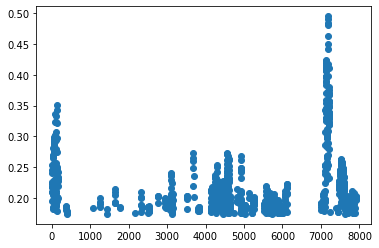

In [55]:
plt.scatter(wind_dists_act.index[wind_dists_act.index.isin(consec_inds)], wind_dists_act.loc[consec_inds])

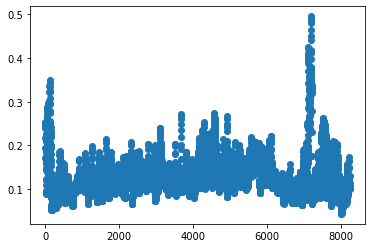

In [56]:
plt.scatter(wind_dists_act.index, wind_dists_act)

In [64]:
consec_inds[(consec_inds>6000)&(consec_inds<7000)]

Int64Index([6016, 6017, 6056, 6057, 6058, 6059, 6060, 6061, 6062, 6063, 6083,
            6109, 6110, 6111, 6112, 6113, 6114, 6115, 6116, 6992, 6993, 6994,
            6995, 6996, 6997],
           dtype='int64', name='frame_num')

In [66]:
6056*3

18168